In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
True


# 1. Dataset 

#### Mnist preview

In [2]:
%%capture
import torchvision

dataset = torchvision.datasets.MNIST(root='/tmp/mnist', download=True)

Label: 5


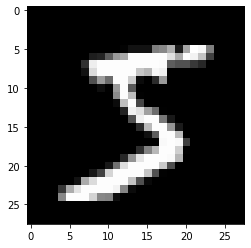

In [3]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [4]:
import torchvision.transforms as transforms

# image -> torch tensor
img = transforms.ToTensor()(image)
img.shape

torch.Size([1, 28, 28])

## 1.1 Get dataset

In [5]:
train_dataset = torchvision.datasets.MNIST(
    root='/tmp/mnist',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
test_dataset = torchvision.datasets.MNIST(
    root='/tmp/mnist',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

#### X

In [6]:
print(train_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
print(train_dataset.data.max())
print(test_dataset.data.min())

tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)


#### y

In [8]:
print(train_dataset.targets.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [9]:
print(train_dataset.targets.shape)
print(test_dataset.targets.shape)

torch.Size([60000])
torch.Size([10000])


## 1.2 Dataloader

In [10]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False)

In [11]:
print(len(train_loader))
for Xb_train, yb_train in train_loader:
    print(Xb_train.shape, yb_train.shape)
    Xb_train = Xb_train.view(-1, 784)
    print(Xb_train.shape, yb_train.shape)
    break

469
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 784]) torch.Size([128])


# 2. Model

In [12]:
# Model
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Loss 
ce_loss = nn.CrossEntropyLoss()

# optimizer
adam_opt = torch.optim.Adam(model.parameters())

In [13]:
# Use GPU to train
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

model.to(device)

Using cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

# 3. Train

In [14]:
def fit(train_loader, valid_loader, model, loss_fn, optimizer, n_epochs):
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)

    for i in range(n_epochs):
        # Train by batches
        train_batch_loss = []
        for X_b, y_b in train_loader:
            # Load data to GPU
            X_train, y_train = X_b.to(device), y_b.to(device)

            # reshape the input
            X_train = X_train.view(-1, 784)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            y_train_ = model(X_train)
            loss = loss_fn(y_train_, y_train)

            # Backward
            loss.backward()
            optimizer.step()

            train_batch_loss.append(loss.item())

        # Valid by batches
        valid_batch_loss = []
        for X_valid, y_valid in test_loader:
            # Load data to GPU
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)

            # reshape the input
            X_valid = X_valid.view(-1, 784)

            # fit
            y_valid_ = model(X_valid)
            loss = loss_fn(y_valid_, y_valid)

            valid_batch_loss.append(loss.item())


        # Save losses
        train_loss = np.mean(train_batch_loss)
        valid_loss = np.mean(valid_batch_loss)
        train_losses[i] = train_loss
        valid_losses[i] = valid_loss
            
        if (i+1) % 2 == 0:
            print(f'Epoch {i+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

    # Plot
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.show()

Epoch 2/20, Train Loss: 0.1954, Valid Loss: 0.1615
Epoch 4/20, Train Loss: 0.1109, Valid Loss: 0.1085
Epoch 6/20, Train Loss: 0.0733, Valid Loss: 0.0876
Epoch 8/20, Train Loss: 0.0521, Valid Loss: 0.0772
Epoch 10/20, Train Loss: 0.0375, Valid Loss: 0.0793
Epoch 12/20, Train Loss: 0.0275, Valid Loss: 0.0691
Epoch 14/20, Train Loss: 0.0193, Valid Loss: 0.0698
Epoch 16/20, Train Loss: 0.0140, Valid Loss: 0.0733
Epoch 18/20, Train Loss: 0.0102, Valid Loss: 0.0730
Epoch 20/20, Train Loss: 0.0082, Valid Loss: 0.0715


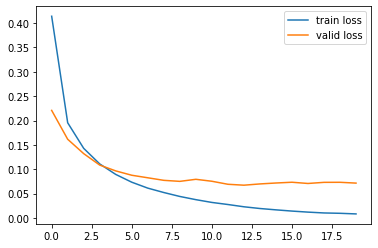

In [15]:
valid_loader = test_loader

fit(train_loader, valid_loader,
    model=model, loss_fn=ce_loss, optimizer=adam_opt,
    n_epochs=20)

# 4. Test

#### Accuracy

In [16]:
n_correct = 0.
n_total = 0.
for Xb_test, yb_test in test_loader:
    # Load data to GPU
    Xb_test, yb_test = Xb_test.to(device), yb_test.to(device)

    # reshape the input
    Xb_test = Xb_test.view(-1, 784)

    # Fit
    yb_test_ = model(Xb_test)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(yb_test_, 1)
  
    # update counts
    n_correct += (predictions == yb_test).sum().item()
    n_total += yb_test.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.9788


#### Confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(
    cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[ 969    0    0    1    1    1    2    1    4    1]
 [   0 1126    2    1    0    1    2    1    2    0]
 [   4    4  998    4    2    0    3    6   10    1]
 [   1    0    4  984    1    5    1    2    6    6]
 [   2    0    4    0  957    0    4    3    1   11]
 [   2    1    0    5    1  873    3    1    5    1]
 [   5    2    2    1    1    5  942    0    0    0]
 [   2    4    8    2    0    0    0 1002    4    6]
 [   1    0    3    2    4    5    2    3  949    5]
 [   0    3    0    4    6    4    1    2    1  988]]


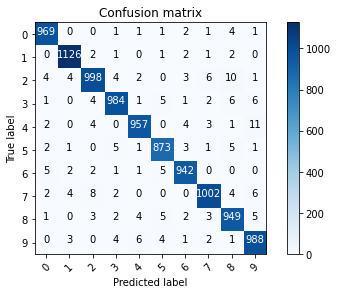

In [18]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for Xb_test, yb_test in test_loader:
    # Load data to GPU
    Xb_test, yb_test = Xb_test.to(device), yb_test.to(device)

    # reshape the input
    Xb_test = Xb_test.view(-1, 784)

    # Fit
    yb_test_ = model(Xb_test)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(yb_test_, 1)
  
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

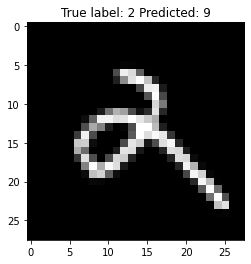

In [19]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));